**Market Risk Indicator**

Could not get exchangeTimezoneName for ticker '' reason: 'chart'
[*********************100%%**********************]  5 of 5 completed

1 Failed download:
['']: %ticker%Y%ticker%F%ticker%T%ticker%z%ticker%M%ticker%i%ticker%s%ticker%s%ticker%i%ticker%n%ticker%g%ticker%E%ticker%r%ticker%r%ticker%o%ticker%r%ticker%(%ticker%'%ticker%$%ticker%:%ticker% %ticker%p%ticker%o%ticker%s%ticker%s%ticker%i%ticker%b%ticker%l%ticker%y%ticker% %ticker%d%ticker%e%ticker%l%ticker%i%ticker%s%ticker%t%ticker%e%ticker%d%ticker%;%ticker% %ticker%N%ticker%o%ticker% %ticker%t%ticker%i%ticker%m%ticker%e%ticker%z%ticker%o%ticker%n%ticker%e%ticker% %ticker%f%ticker%o%ticker%u%ticker%n%ticker%d%ticker%'%ticker%)%ticker%


Ticker           EVZ        ^GSPC      ^MOVE   ^VIX
Date                                               
2024-05-17 NaN  0.32  5303.270020  89.349998  11.99
2024-05-20 NaN  0.32  5308.129883  88.129997  12.15
2024-05-21 NaN  0.32  5321.410156  85.339996  11.86
2024-05-22 NaN  0.32  5307.009766  82.489998  12.29
2024-05-23 NaN  0.32  5267.839844  86.150002  12.77
Using lookback periods: [5, 10, 22, 66, 90, 10] days with slope factor 10
Date
2024-05-17    0.182454
2024-05-20    0.211155
2024-05-21    0.265383
2024-05-22    0.188542
2024-05-23    0.102795
dtype: float64


/var/folders/w6/pmmfklps59z60whl_87vd6gm0000gn/T/ipykernel_47935/2033560069.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  today_val = y[-1]
/var/folders/w6/pmmfklps59z60whl_87vd6gm0000gn/T/ipykernel_47935/2033560069.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  today_val = y[-1]


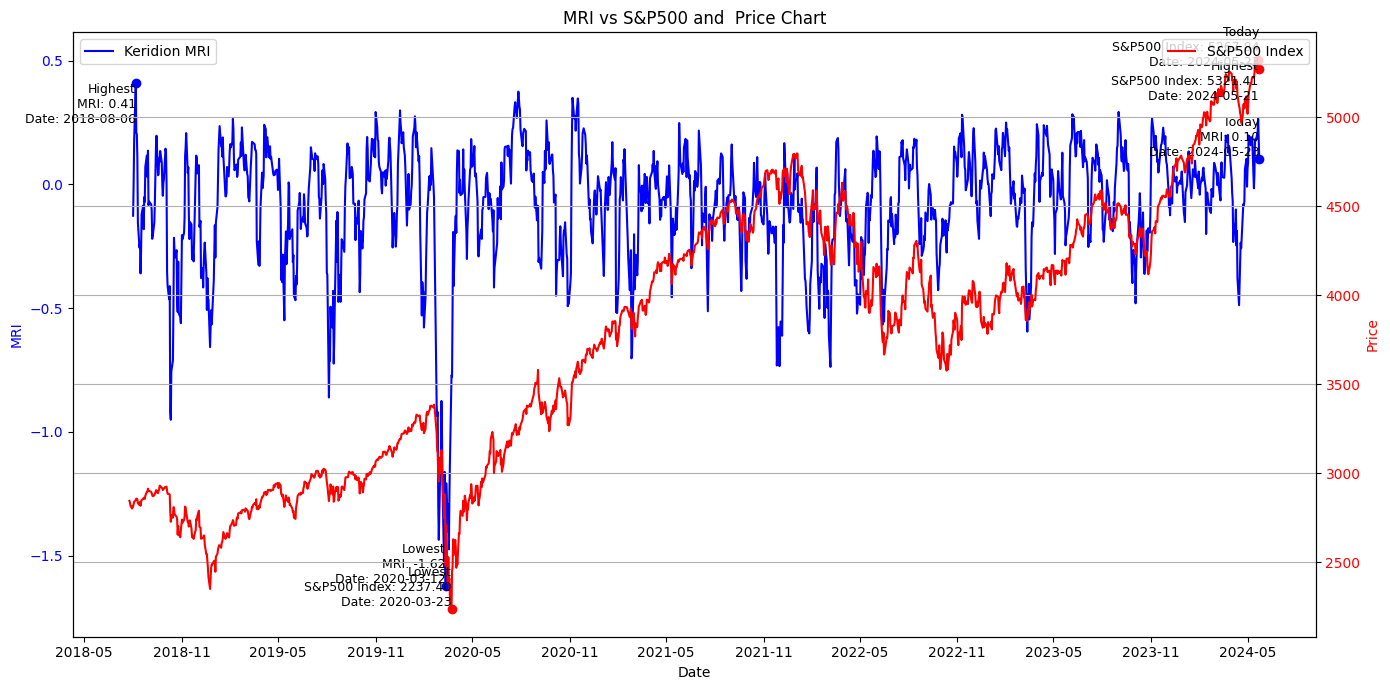

In [102]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def get_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    # Handle NaN values for all columns
    data = data['Close'].ffill().bfill()  # Forward-fill NaNs, then backward-fill if needed
    return data

def calculate_mri(data, lookback_periods, weights, slope_factor):
    # Calculate daily returns
    daily_returns = (data - data.shift(1)) / data.shift(1)
    
    # Extract the comparison indices
    comparison_index = daily_returns[['^VIX', '^MOVE', 'EVZ']]
    
    # Calculate the MRI for each lookback period and average them
    mri_list = []
    for lookback in lookback_periods:
        offset_values = {}
        for ticker in comparison_index.columns:
            offset_values[ticker] = -comparison_index[ticker].rolling(window=lookback).sum()
        
        # Convert offset_values dict to DataFrame
        offset_values_df = pd.DataFrame(offset_values).dropna()
        
        # Calculate MRI for this lookback period
        mri = offset_values_df.apply(lambda row: np.dot(row, weights), axis=1) / np.sqrt(lookback)
        mri_list.append(mri)
    
    # Average the MRIs and apply the slope factor
    mri_avg = pd.concat(mri_list, axis=1).mean(axis=1) * slope_factor
    return mri_avg

def annotate_points(ax, x, y, label, color):
    """ Annotate specific points on the plot with date and value using dots, moving all labels to the top-left. """
    # Annotate highest point
    highest_idx = y.idxmax()
    highest_val = y.max()
    ax.plot(highest_idx, highest_val, 'o', color=color)  # Dot for highest point
    ax.text(highest_idx, highest_val, f'Highest\n{label}: {highest_val:.2f}\nDate: {highest_idx.strftime("%Y-%m-%d")}', 
            color='black', fontsize=9, ha='right', va='top')
    
    # Annotate lowest point
    lowest_idx = y.idxmin()
    lowest_val = y.min()
    ax.plot(lowest_idx, lowest_val, 'o', color=color)  # Dot for lowest point
    ax.text(lowest_idx, lowest_val, f'Lowest\n{label}: {lowest_val:.2f}\nDate: {lowest_idx.strftime("%Y-%m-%d")}', 
            color='black', fontsize=9, ha='right', va='bottom')
    
    # Annotate today's point
    today_idx = y.index[-1]
    today_val = y[-1]
    ax.plot(today_idx, today_val, 'o', color=color)  # Dot for today's point
    ax.text(today_idx, today_val, f'Today\n{label}: {today_val:.2f}\nDate: {today_idx.strftime("%Y-%m-%d")}', 
            color='black', fontsize=9, ha='right', va='bottom')

def plot_data(data, mri, gspc_ticker='^GSPC', user_ticker=None, start_date=None, end_date=None):
    # Filter data for the specified date range
    if start_date is not None and end_date is not None:
        data = data.loc[start_date:end_date]
        mri = mri.loc[start_date:end_date]
    
    plt.figure(figsize=(14, 7))
    
    # Plot MRI on the primary y-axis
    ax1 = plt.gca()
    ax1.plot(mri.index, mri, label='Keridion MRI', color='blue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('MRI', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Annotate MRI points
    annotate_points(ax1, mri.index, mri, 'MRI', 'blue')
    
    # Create a secondary y-axis for the default S&P 500 Index and the user-defined ticker
    ax2 = ax1.twinx()
    
    # Plot S&P 500 Index
    ax2.plot(data.index, data[gspc_ticker], label='S&P500 Index', color='red')
    annotate_points(ax2, data.index, data[gspc_ticker], 'S&P500 Index', 'red')
    
    # Plot user-defined ticker if provided
    if user_ticker and user_ticker in data.columns:
        ax2.plot(data.index, data[user_ticker], label=f'{user_ticker} Price', color='green')
        annotate_points(ax2, data.index, data[user_ticker], f'{user_ticker} Price', 'green')
    
    ax2.set_ylabel('Price', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Center MRI around 0 by setting y-axis limits
    mri_min, mri_max = mri.min(), mri.max()
    margin = (mri_max - mri_min) * 0.1  # 10% margin around min and max
    ax1.set_ylim(mri_min - margin, mri_max + margin)
    
    # Format x-axis to show labels every 2 months
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    # Create a dynamic title using f-strings
    plt.title(f"MRI vs S&P500 and {user_ticker} Price Chart")
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main part of the script
# Predefined tickers
tickers = ['^VIX', '^MOVE', 'EVZ', '^GSPC']
start_date = (datetime.datetime.now() - pd.DateOffset(years=6)).strftime('%Y-%m-%d')

# Take additional stock ticker from user
user_ticker = input("Enter the ticker symbol of a stock you want to add: ").upper()
tickers.append(user_ticker)

# Get end date from user, default to current date if not provided
end_date_input = input("Enter the end date (YYYY-MM-DD) or press Enter to use the current date: ")
if end_date_input:
    end_date = end_date_input
else:
    end_date = datetime.datetime.now().strftime('%Y-%m-%d')

data = get_data(tickers, start_date, end_date)
print(data.tail())

# Choose Fast (1) or Slow (0) and determine the lookback period
# Default to Fast (1) if no input is provided
fast_slow_choice = input("Choose Fast (1) or Slow (0) [default is Fast]: ")
if not fast_slow_choice:
    fast_slow_choice = 1
else:
    fast_slow_choice = int(fast_slow_choice)

# Define the lookback periods
lookback_periods = {
    1: [5, 10, 22, 66, 90, 10],
    0: [66, 126, 190, 252, 520, 22]
}

# Determine the lookback value based on the user's choice
if fast_slow_choice in lookback_periods:
    selected_periods = lookback_periods[fast_slow_choice]
else:
    raise ValueError("Invalid choice. Enter 1 for Fast or 0 for Slow.")

# Determine the slope factor based on the user's choice
slope_factor = 10 if fast_slow_choice == 1 else 22

print(f"Using lookback periods: {selected_periods} days with slope factor {slope_factor}")

# Input weights from user
weights_input = input("Enter the weights for ^VIX, ^MOVE, and EVZ (comma separated, in percentage): ")
if weights_input:
    weights = [float(w) / 100 for w in weights_input.split(',')]
else:
    weights = [1/3, 1/3, 1/3]  # Default weights to 33.3% each

data_mri = calculate_mri(data, selected_periods, weights, slope_factor)
print(data_mri.tail())

# Plotting the data daily with x-axis labels every 2 months
plot_data(data, data_mri, gspc_ticker='^GSPC', user_ticker=user_ticker, start_date=start_date, end_date=end_date)

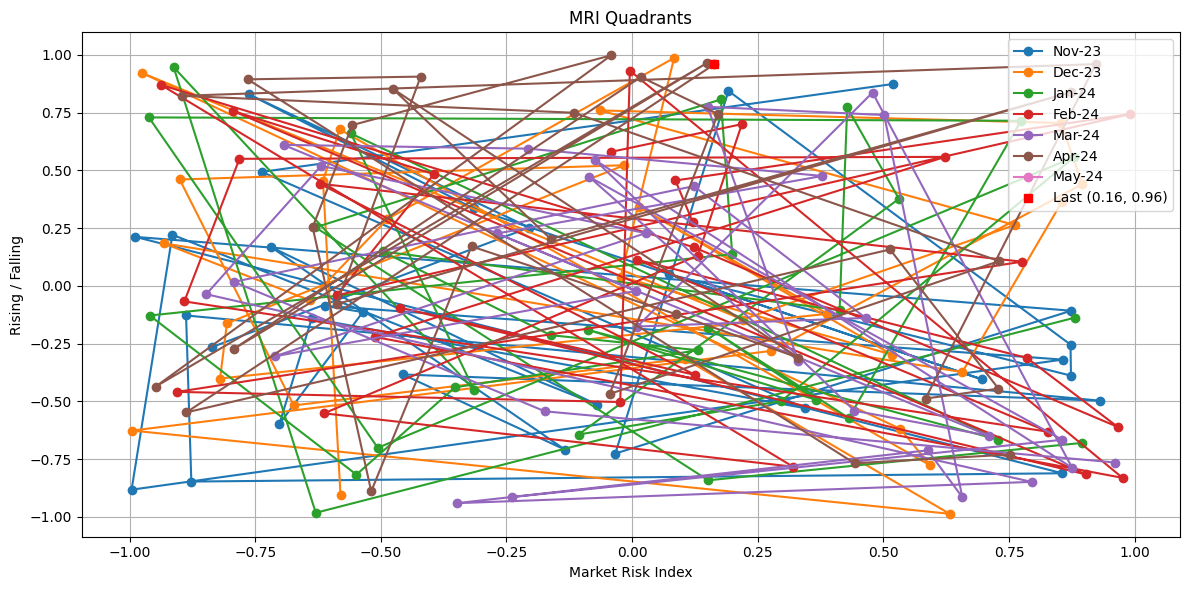

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Example data setup
# Assume we have data in the format: date, rising/falling metric, MRI value
# Replace this with your actual data
dates = pd.date_range(start='2023-11-01', periods=180, freq='D')
mri_values = np.random.rand(len(dates)) * 2 - 1  # MRI values between -1 and 1
rising_falling = np.random.rand(len(dates)) * 2 - 1  # Rising/falling metric between -1 and 1

# For visualization, we create multiple series to represent different months
# This is a simplification, in practice, you should use your actual data
months = ['Nov-23', 'Dec-23', 'Jan-24', 'Feb-24', 'Mar-24', 'Apr-24', 'May-24']
monthly_data = {month: (rising_falling[i*30:(i+1)*30], mri_values[i*30:(i+1)*30]) for i, month in enumerate(months)}

# Plotting
plt.figure(figsize=(12, 6))

for month, (rise_fall, mri) in monthly_data.items():
    plt.plot(mri, rise_fall, marker='o', label=month)

# Annotate the last point for emphasis
last_mri, last_rise_fall = mri_values[-1], rising_falling[-1]
plt.plot(last_mri, last_rise_fall, 's', color='red', label=f'Last ({last_mri:.2f}, {last_rise_fall:.2f})')

# Adding labels and legend
plt.xlabel('Market Risk Index')
plt.ylabel('Rising / Falling')
plt.title('MRI Quadrants')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()